# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Class-based outlier removal](#Class-based-outlier-removal)
* [Results](#Results)

# Introduction

To speed development, 5-fold train-test splits were preprocessed and prepared as separate .feather files. Outliers were removed from training data using LocalOutlierFactor in a previous notebook. The data were further preprocessed by using Linear Discriminant Analysis to generate two components. This notebook further removes outliers per class based on the LDA components.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import pandas as pd

# utility
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.01 s


In [4]:
# Location of CV .feather files
CV_FEATHERS_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = CV_FEATHERS_FOLDER

_ = gc_collect()

time: 86.1 ms


# Class-based outlier removal

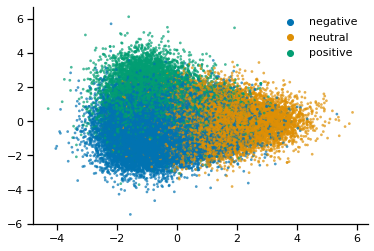

removed 72 outliers
removed 43 outliers
removed 58 outliers


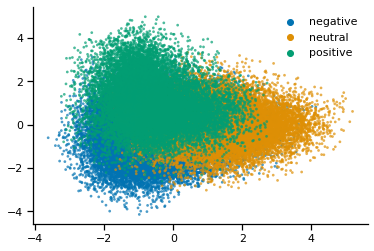

fold 1 completed in 5.77 s


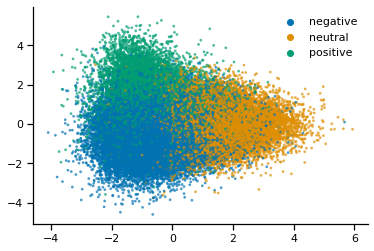

removed 55 outliers
removed 49 outliers
removed 64 outliers


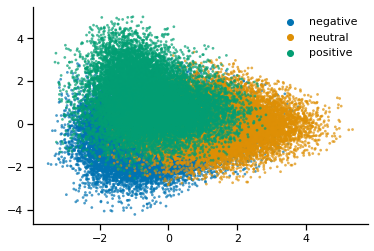

fold 2 completed in 6.09 s


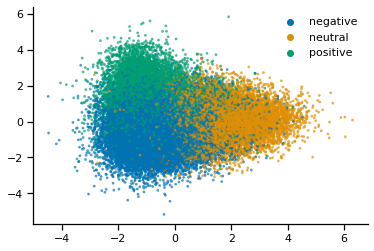

removed 57 outliers
removed 48 outliers
removed 71 outliers


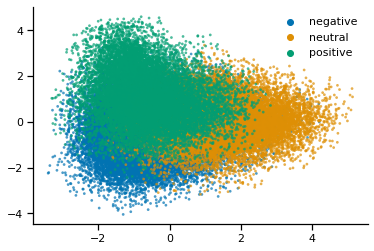

fold 3 completed in 5.81 s


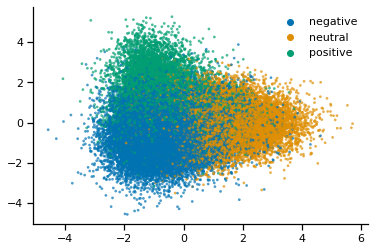

removed 59 outliers
removed 56 outliers
removed 46 outliers


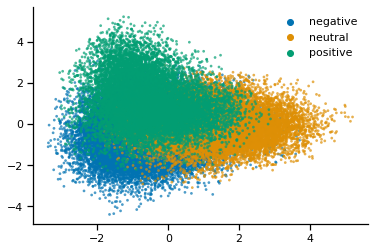

fold 4 completed in 5.09 s


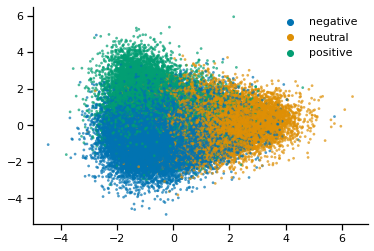

removed 63 outliers
removed 53 outliers
removed 62 outliers


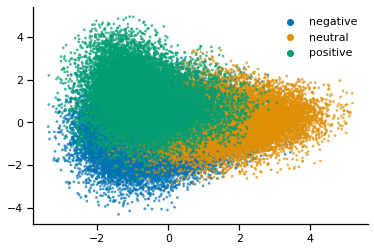

fold 5 completed in 6.28 s
time: 29.7 s


In [5]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Remove outliers with LOF"""
    size = len(df)
    df = df.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(df) == 1]
    print(f"removed {size - len(df)} outliers")
    return df


def visualize_LDA_components(x: pd.DataFrame, y: pd.Series) -> None:
    """Plot a scatter plot of two LDA components colored by class"""
    sns.scatterplot(
        x=x.LDA1,
        y=x.LDA2,
        hue=y.replace([0, 1, 2], ["negative", "neutral", "positive"]),
        palette="colorblind",
        hue_order=["negative", "neutral", "positive"],
        alpha=0.7,
        legend="brief",
        linewidth=0,
        marker=".",
        s=30,
    )
    sns.despine(**dict.fromkeys(("top", "right"), True))
    plt.legend(frameon=False)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()


_ = gc_collect()

fold_num = 0
while True:
    fold_begin = time()

    # load training data
    path_prefix = f"{CV_FEATHERS_FOLDER}/cv_{fold_num}"
    try:
        X_train: pd.DataFrame = pd.read_feather(
            f"{path_prefix}/X_train_LOF-LDA.feather"
        )
        X_train_FRILL: pd.DataFrame = pd.read_feather(
            f"{path_prefix}/X_train_LOF.feather"
        )
        y_train: pd.Series = pd.read_feather(f"{path_prefix}/y_train_LOF.feather").iloc[
            :, 0
        ]
    except FileNotFoundError:
        break

    # visualize before
    visualize_LDA_components(X_train, y_train)

    # remove outliers
    X_train = pd.concat([remove_outliers(X_train.loc[y_train == i]) for i in range(3)])
    y_train = y_train.loc[X_train.index]

    # visualize after
    visualize_LDA_components(X_train, y_train)

    # attach FRILL embeddings to filtered X_train
    X_train = pd.concat([X_train_FRILL.loc[X_train.index], X_train], axis="columns")
    del X_train_FRILL
    _ = gc_collect()

    # save X_train
    X_train.sort_index().reset_index(drop=True).to_feather(
        f"{path_prefix}/X_train_LOF-LDA-classLOF.feather"
    )
    del X_train
    _ = gc_collect()
    # save y_train
    pd.DataFrame(y_train.sort_index().reset_index(drop=True)).to_feather(
        f"{path_prefix}/y_train_LOF-LDA-classLOF.feather"
    )
    del y_train
    del path_prefix
    _ = gc_collect()

    print(f"fold {fold_num + 1} completed in {time() - fold_begin:.2f} s")
    del fold_begin
    _ = gc_collect()

    fold_num += 1

# Results

Let's peek at the results.

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,LDA1,LDA2
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.062330,-0.528231,-0.289786
1,0.101377,-0.063714,-0.015971,-0.151561,-0.065328,-0.013746,0.008821,0.010461,-0.030857,-0.010367,...,0.114774,-0.033263,-0.071615,-0.040535,-0.050813,0.021136,-0.189459,0.040756,-1.347100,0.531303
2,-0.028015,-0.041617,0.012599,-0.031460,0.021788,0.039503,0.033654,0.114422,-0.080653,-0.032090,...,0.044898,0.008499,0.009812,-0.047551,0.085392,0.029538,0.057070,-0.029945,-0.820677,-0.848767
3,-0.008712,-0.003798,-0.052170,0.030298,0.049662,0.039806,0.056743,-0.186714,-0.151110,0.021191,...,-0.067552,-0.017051,-0.109469,-0.082999,-0.049325,0.031638,-0.027172,0.006479,-1.192168,-0.155558
4,-0.000265,-0.050629,-0.005011,-0.169305,-0.087526,-0.022268,-0.020403,-0.149949,-0.047235,0.032980,...,0.047202,-0.024305,-0.168291,0.112876,0.017571,0.078376,0.099279,-0.046610,-1.554612,-0.648507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72006 entries, 0 to 72005
Columns: 2050 entries, 0 to LDA2
dtypes: float32(2048), float64(2)
memory usage: 563.6 MB


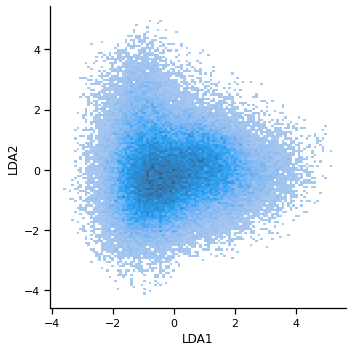

,0
0,0
1,0
2,0
3,0
4,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73941 entries, 0 to 73940
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       73941 non-null  int8 
dtypes: int8(1)
memory usage: 72.3 KB


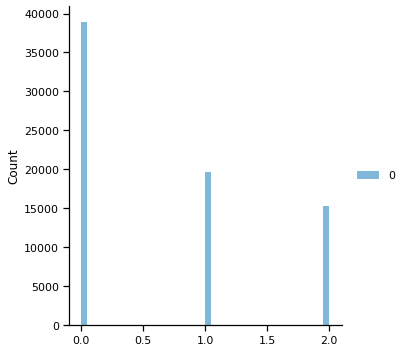

time: 2.03 s


In [6]:
_ = pd.read_feather("./cv_0/X_train_LOF-LDA-classLOF.feather")
_.head(5)
_.info()

sns.displot(x=_.LDA1, y=_.LDA2, palette="colorblind")
sns.despine(**dict.fromkeys(["top", "right"], True))
plt.show()

_ = pd.read_feather("./cv_1/y_train_LOF-LDA-classLOF.feather")
_.head(5)
_.info()

sns.displot(data=_, palette="colorblind", linewidth=0)
sns.despine(**dict.fromkeys(["top", "right"], True))
plt.show()

In [7]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 38.084397077560425 s
time: 112 ms


[^top](#Contents)